In [60]:
# Esse é um case de modelagem, que utiliza a base de dados do Thera bank, disponibilizado pela DNC Group, para um exercício de análise de dados e classificação.
# Exercício resolvido por Rian Rodrigues de Oliveira como parte do curso de Data Expert da DNC Group.

# Esse case se divide em duas grandes partes: Primeiro, faremos uma análise descritiva dos dados
# Depois, criaremos um modelo de classificação utilizando o método dos K-Nearest Neighbors
# Nessa segunda parte também utilizaremos o método de Validação Cruzada para obter o melhor valor de K para o modelo.


#Inicialmente, baixaremos as bibliotecas que serão utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# Importação dos dados
from google.colab import files
files.upload()

{}

In [62]:
df = pd.read_excel('[Copy] - Bank_Personal_Loan_Modelling.xlsx', sheet_name = "Data")

1. Análise Descritiva dos dados

In [63]:
df.shape

(5000, 14)

In [64]:
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [65]:
df.dtypes

ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object

Eis a informação que o dataset original nos oferece:

ID - ID do Cliente

Age -	Idade em anos

Experience - Experiência profissional, em anos;

Income -	Renda anual, em milhares de dólares

ZIPCode - Código ZIP, uma espécie de CEP dos EUA.

Family -	Tamanho da família

CCAvg	 - Gasto da família com cartão de crédito, por mês, em milhares de dólares

Education - Educação, colocada em três níveis: 1: Ensino Superior Incompleto, 2: Ensino Superior Completo, 3: Pós-Graduação

Mortgage - Valor do financiamento (hipoteca) da casa, se presente, em milhares de dólares.

Personal Loan - Se o cliente aceitou um empréstimo pessoal na última campanha do banco. 1 caso sim, 0 caso não.

Securities Account - Se o cliente possui uma conta de títulos no banco. 1 caso sim, 0 caso não.

CD Account - Se o cliente possui uma conta de certificado de depósito (CD) no banco.  1 caso sim, 0 caso não.

Online - Se o cliente usa o banco pela internet.  1 caso sim, 0 caso não.

CreditCard - Se o cliente possui um cartão de crédito emitido pelo UniversalBank.  1 caso sim, 0 caso não.

In [66]:
# As variáveis ZIP Code e ID do cliente não serão úteis para nós, pois são utilizadas pelo o banco apenas para identificar o cliente.

df = df.drop(columns=['ZIP Code','ID'])

In [67]:
#Checando a presença de nulos:

df.isnull().sum()

Age                   0
Experience            0
Income                0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [68]:
#Checando a presença de dados duplicados:

df.duplicated().value_counts()

False    4987
True       13
dtype: int64

In [69]:
#O dataset possui 0 valores nulos e 13 linhas repetidas. Removeremos as linhas repetidas antes de continuar.
#Como são apenas 13 linhas, no final do processo devemos ter 4987 linhas e 12 colunas no shape.

df = df.drop_duplicates()

In [70]:
df.shape

(4987, 12)

In [71]:
# Estatística Descritiva das variáveis

df.describe(percentiles=[.05,.10,.25,.50,.75,.90,.95,.99]).transpose()

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
Age,4987.0,45.347704,11.460838,23.0,27.0,30.0,35.0,45.0,55.0,61.0,63.0,65.00,67.0
Experience,4987.0,20.114498,11.464902,-3.0,2.0,4.0,10.0,20.0,30.0,36.0,38.0,41.00,43.0
Income,4987.0,73.824544,46.062728,8.0,18.0,22.0,39.0,64.0,98.0,145.0,170.0,193.00,224.0
Family,4987.0,2.396631,1.147510,1.0,1.0,1.0,1.0,2.0,3.0,4.0,4.0,4.00,4.0
CCAvg,4987.0,1.940606,1.748831,0.0,0.1,0.3,0.7,1.5,2.6,4.3,6.0,8.00,10.0
Education,4987.0,1.879286,0.839667,1.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.00,3.0
Mortgage,4987.0,56.646080,101.805341,0.0,0.0,0.0,0.0,0.0,101.0,200.0,272.0,431.14,635.0
Personal Loan,4987.0,0.096250,0.294964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00,1.0
Securities Account,4987.0,0.104672,0.306161,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.0
CD Account,4987.0,0.060557,0.238541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00,1.0


Vale apontar também que a variável Experience apresenta valores anormais, pois existem valores negativos na mesma e não é possível alguém ter "menos três anos" de experiência de trabalho. Esse pequeno distúrbio pode ter sido causado por erro humano, e será tratado antes de seguirmos para a modelagem. 

In [72]:
df[df['Experience'] < 0]['Experience'].value_counts()

-1    33
-2    15
-3     4
Name: Experience, dtype: int64

In [79]:
# Aplicaremos np.abs para remover os valores negativos da base.
df['Experience'] = df['Experience'].apply(np.abs)

In [80]:
df[df['Experience'] < 0]['Experience'].value_counts()

Series([], Name: Experience, dtype: int64)

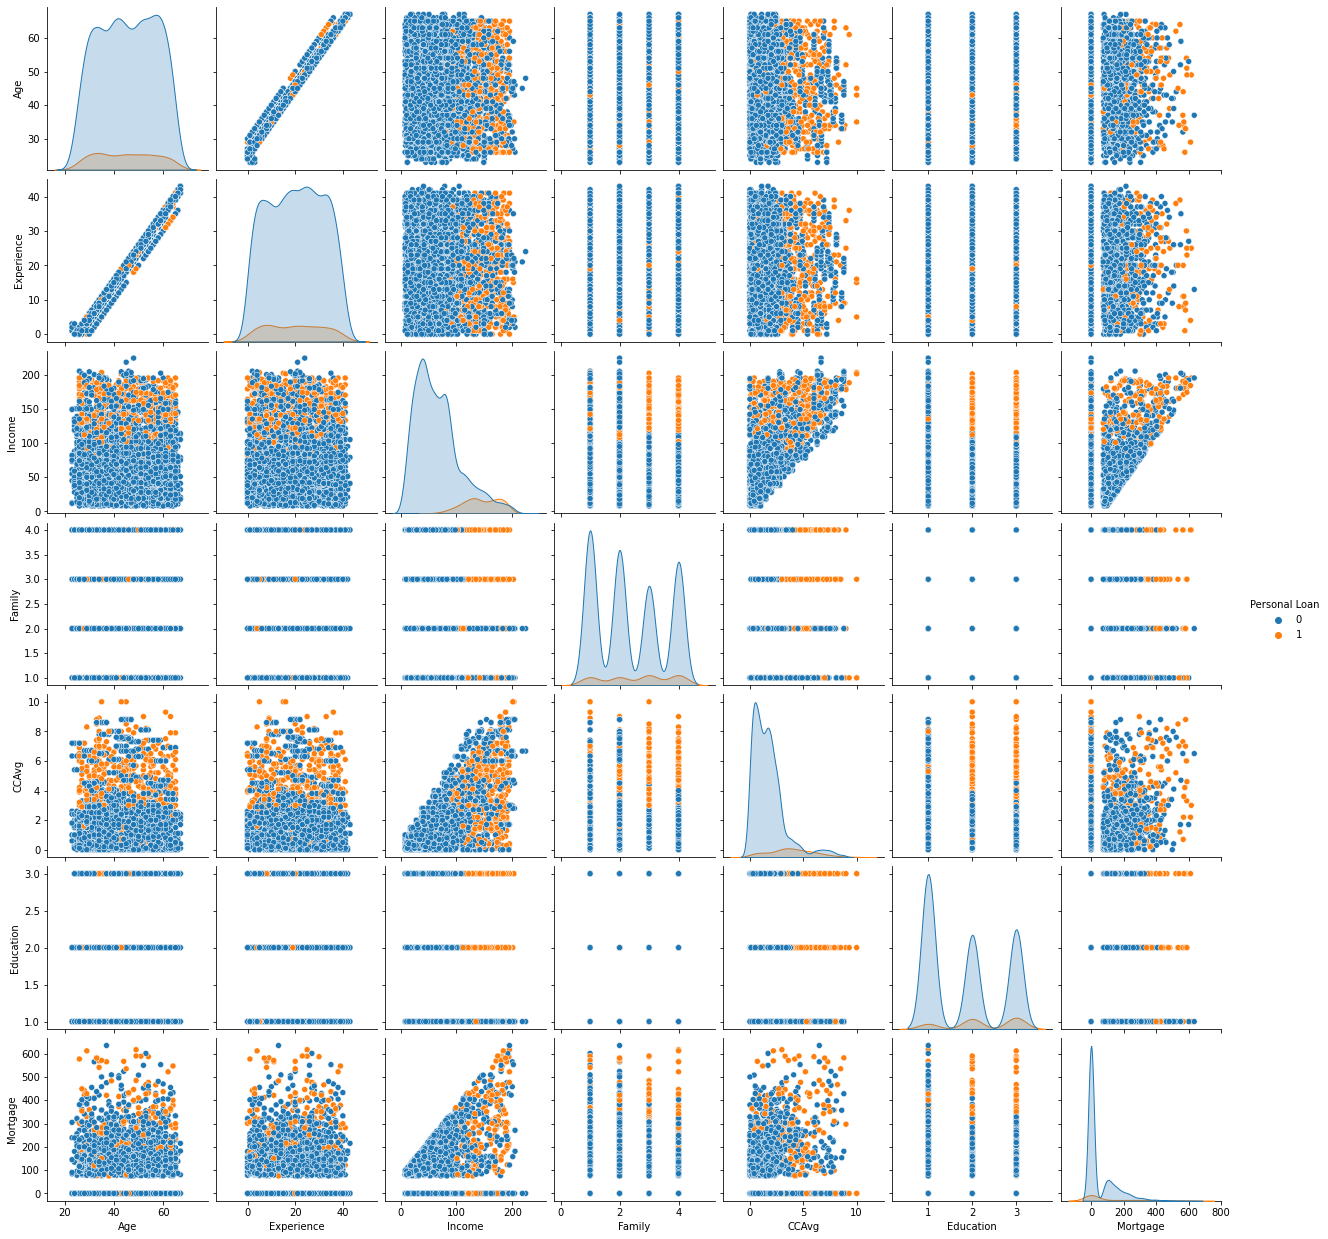

In [81]:
# Vamos plotar o relacionamento entre as variáveis para buscar tendências da variável target.
# Por motivos de visualização, o código a seguir faz essa plotagem, para as variáveis numéricas, incluindo na análise educação e família.
# Analisaremos as outras variáveis mais adiante.


sns.pairplot(df, hue='Personal Loan', vars=['Age', 'Experience','Income','Family','CCAvg','Education','Mortgage'])
plt.show()

Com o pairplot, podemos verificar os relacionamentos entre as variáveis numéricas. Nos gráficos acima, os pontos laranjas são os clientes cuja variável target (Personal Loan, se o cliente fez um empréstimo com o banco anteriormente) é igual a 1. Os pontos azuis são quando a variável target é igual a zero.

Age: Os clientes target costumam ser de todas as idades.

Experience: Os clientes target costumam ser de todas os anos de experiência.

Income: A tomada de empréstimo está fortemente concentrada nos clientes que possuem uma renda superior a 100 mil dólares por ano.

Family: os clientes com 3 ou 4 filhos tem uma tendência maior de tomar empréstimos pessoais.

CCavg: o terceiro quartil desta variável é de 2.6, o que significa que três quartos da amostra analisada possuem valores de gasto mensal médio com cartões de crédito inferior a dois mil e seiscentos dólares. Os clientes target estão bem concentrados no quarto quartil.

Education: os clientes com nível de educação 2 (Superior completo) ou 3 (Pós-Graduação) costumam tomar mais empréstimos pessoais.

Mortgage: os clientes target costumam ter pouca ou nenhuma hipoteca para pagar.


In [82]:
# Vamos agora obter a correlação de todas as variáveis com a variável target.
# Utilizaremos a correlação de pearson, e o usaremos a transposição para melhorar a visualização dos dados que desejamos obter.

In [83]:
dfcorr = df.corr(method='pearson').transpose()

In [84]:
dfcorr['Personal Loan']

Age                  -0.008003
Experience           -0.008604
Income                0.502513
Family                0.061398
CCAvg                 0.366672
Education             0.137618
Mortgage              0.141700
Personal Loan         1.000000
Securities Account    0.021670
CD Account            0.316210
Online                0.006718
CreditCard            0.002399
Name: Personal Loan, dtype: float64

Então, as variáveis que mais possuem correlação positiva com a nossa variável target são, respectivamente: a renda, o gasto médio mensal com o cartão de crédito, a presença de uma conta de certificado de depósito, a hipoteca e o nível de educação do cliente. As outras variáveis apresentam correlação menor do que 0.1

Parte 2) Modelagem de um modelo de classificação utilizando K-Nearest Neighbors e Cross Fold Validation.

In [90]:
# Vamos agora começar a modelagem. Primeiro, importar as bibliotecas que utilizaremos
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

In [91]:
# Dividindo as variáveis explicativas e dependentes
x = df.drop(columns=['Personal Loan'])
y = df['Personal Loan']

In [92]:
# Utilizaremos K=3 para o número de neighbors(vizinhos) e K=10 para o número de dobras
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, x, y, cv=10, scoring='accuracy')
print(scores)

[0.90581162 0.90981964 0.90781563 0.91182365 0.92184369 0.91983968
 0.90380762 0.91164659 0.91365462 0.91365462]


In [93]:
# A função cross_val_score retorna um array de scores. Precisamos então obter a média deste array

scores.mean()

0.9119717346339264

Para 10 folds e 3 vizinhos mais próximos, obtivemos uma acurácia média de 91%. Utilizaremos agora o Cross Fold Validation para verificar se conseguimos descobrir um número de vizinhos que melhora a acurácia do modelo.

In [94]:
k_teste = range(1,51)
k_scores = []

for k in k_teste:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, x, y, cv=10, scoring='accuracy')
  k_scores.append(scores.mean())

print(k_scores)

[0.9083641177938206, 0.9139761450612068, 0.9119717346339264, 0.9111693266050175, 0.9141757410403137, 0.9111685217825208, 0.9119709298114301, 0.9121725378467781, 0.9137745370258591, 0.9119697225776855, 0.9127709233728503, 0.9113681177616278, 0.9093633049230991, 0.910364906519867, 0.9091620992989997, 0.908358886447594, 0.9081584856459909, 0.9083592888588422, 0.9077580864540327, 0.9059516623608662, 0.9061536728074623, 0.9055508607576599, 0.9061532703962142, 0.9073564800283297, 0.904952877642836, 0.9077584888652808, 0.9067564848572648, 0.9091612944765032, 0.9083592888588422, 0.9091600872427585, 0.9085592872491974, 0.9081572784122462, 0.9075564784186849, 0.9087596880508004, 0.9075564784186849, 0.9087596880508004, 0.9087600904620485, 0.9085596896604455, 0.9071560792267265, 0.9071564816379748, 0.9081580832347426, 0.907958889666884, 0.907756879220288, 0.9091608920652551, 0.9069556784251235, 0.9085608968941902, 0.9081580832347426, 0.9079576824331396, 0.907355272794585, 0.9089596864411554]


In [99]:
# Para facilitar a visualização, iremos buscar o valor máximo da lista e o index deste valor
# Como listas começam com index 0, adicionaremos 1 a este valor para obter o valor de k vizinhos
# que maximiza a acurácia do modelo


score_max = max(k_scores)
max_k = k_scores.index(score_max)
print(score_max)
print(max_k+1)

0.9141757410403137
5


Text(0, 0.5, 'Acurácia')

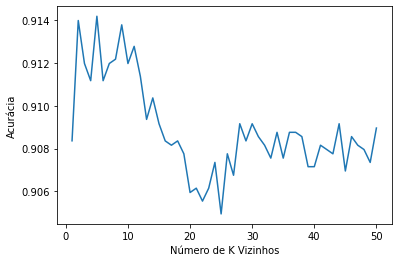

In [95]:
# Plotaremos agora como a acurácia do modelo aumenta ou diminiu conforme aumentamos o número de K.

plt.plot(k_teste, k_scores)
plt.xlabel("Número de K Vizinhos")
plt.ylabel('Acurácia')

Portanto, o valor de K que maximiza a acurácia do modelo de K-Vizinhos mais próximos, utilizando uma validação cruzada que divide a base de dados em 10 subconjuntos, é K = 5

Estatística Descritiva, Modelagem e Código feito por
Rian Rodrigues de Oliveira